#HOG + PCA + NN + SVM v3

In [ ]:
#Old Unsupported GPUs 
import tensorflow as tf
DEVICES=tf.config.experimental.list_physical_devices()
print('GPU Availability : ',tf.test.is_gpu_available())
tf.config.experimental.set_memory_growth(device=DEVICES[1],enable=True)

GPU Availability :  True


In [ ]:
# Nvidia Only
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
import os
import cv2
import glob
#import h5py
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf

#from pathlib import Path
#from imutils import paths
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from skimage.feature import hog
from sklearn.decomposition import PCA , IncrementalPCA
from sklearn.preprocessing import StandardScaler

#from sklearn.model_selection import train_test_split
#from skimage import color, io, exposure, feature, util ,img_as_ubyte, transform

from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop,Adam,SGD
#from tensorflow.keras.callbacks import LearningRateScheduler
#from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import Activation, Dense, Flatten, Input, InputLayer, Dropout

In [ ]:
def HOG(imagePath):
    H=[]
    image = cv2.imread(imagePath)
    #image = cv2.bitwise_not(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.3, tileGridSize=(8,8))
    img = clahe.apply(gray)
    imS = cv2.resize(img, (225, 255)) 
    (H, hogImage) = hog(imS, orientations=4,pixels_per_cell=(15,15),cells_per_block=(2,2), transform_sqrt=True, block_norm="L2", visualize=True) 
    #Data Normalisation (Normalising HOG Features)
    #H*=10
    return H

In [ ]:
basedir='./HOG_NN/mataji/Female/7/'
basemodel=basedir+'model_700.h5'
baseweight=basedir+'Weight_550.h5'

In [ ]:
%%script False
data = []
labels = []
traindir='./path/Dataset/ghoshaala/MatajiGaushala'#Enter the Train Directory
for directory_path in glob.glob(traindir+"/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path,"*.png")):
        #print(img_path)
        A = HOG(img_path)
        data.append(A)
        labels.append(label)
np.save(basedir+'data_3.npy',data)
np.save(basedir+'labels.npy',labels)

Couldn't find program: 'False'


In [ ]:
data=np.load(basedir+'data_2.npy')
labels=np.load(basedir+'labels.npy')
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
le = preprocessing.LabelEncoder()
le.fit(labels)
toh= le.transform(labels)
OHE_labels=to_categorical(toh)
n_classes=OHE_labels.shape[1]
print("Classes ",n_classes,)
print("Data    ",data.shape)
print("labels  ",labels.shape)
print("One Hot Labels ",OHE_labels.shape)

Classes  2840
Data     (42599, 2688)
labels   (42599,)
One Hot Labels  (42599, 2840)


In [ ]:
#%%script false
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(data, OHE_labels,
                                                  train_size=0.70,
                                                  random_state=12)
print(
      trainX.shape,'\n',
      testX.shape,'\n',
      trainY.shape,'\n',
      testY.shape,'\n'
      )

(29819, 2688) 
 (12780, 2688) 
 (29819, 2840) 
 (12780, 2840) 



In [ ]:
%%script false
from collections import Counter
print(*Counter(labels))

Couldn't find program: 'false'


Text(0, 0.5, 'Cum variance')

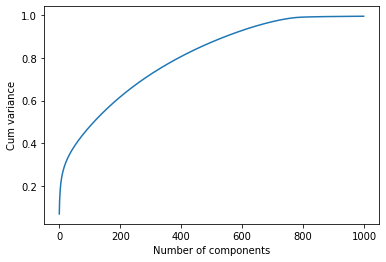

In [22]:
#%%script false
from sklearn.decomposition import PCA
# First verfiy the ideal number of PCA components to not lose much information. 
# Try to retain 90% information, so look where the curve starts to flatten.
# Remember that the n_components must be lower than the number of rows or columns (features)
pca_test = PCA(n_components=1000) 
pca_test = pca_test.fit(data)
#pca_test.fit(data)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cum variance")

In [24]:
#Picking the optimal number of components. 
n_PCA_components = 1000
pca = PCA(n_components=n_PCA_components)
train_PCA = pca.fit_transform(data)
print("Before Trimming : ",train_PCA.shape)

Before Trimming :  (42599, 1000)


In [27]:
from xml.etree.ElementTree import tostring
import plotly.express as px 
comp = 5
graph_pca_test = PCA(n_components=comp) 
graph_pca_test=graph_pca_test.fit_transform(data)

from xml.etree.ElementTree import tostring
import plotly.express as px 
comp = 5
graph_pca_test = PCA(n_components=comp) 
graph_pca_test=graph_pca_test.fit_transform(data)

fig = px.scatter_matrix( graph_pca_test,
    labels=labels,
    dimensions=range(5),
    color=['Red']
    )
fig.update_traces(diagonal_visible=False)
    labels=labels,
    dimensions=range(5),
    color=['Red']
    )
fig.update_traces(diagonal_visible=False)
fig.show()

AttributeError: module 'pandas' has no attribute 'Series'

In [ ]:
# Trim and save 
for i in range(450):
    train_PCA=np.delete(train_PCA,0,1)
print("After Trimming : ",train_PCA.shape)

#test_PCA = pca.transform(testX) #Make sure you are just transforming, not fitting.
#percentage %  Information capturing 
#pca=PCA(0.9)
#train_PCA = pca.fit_transform(data)
#n_PCA_components = len(train_PCA)
#print(principalComponents.shape)

#%%script false
import pickle as pk
pk.dump(pca, open(basedir+"pca_data_3.pkl","wb"))

In [ ]:
# deleting axis 1 (450 times) 
for i in range(450):
    pca_test=np.delete(pca_test,0,1) 
print("After Trimming : ",pca_test.shape)

In [ ]:
# x= n_ classes 
x=[]
for i in range(OHE_labels.shape[1]):
    x.append(i)

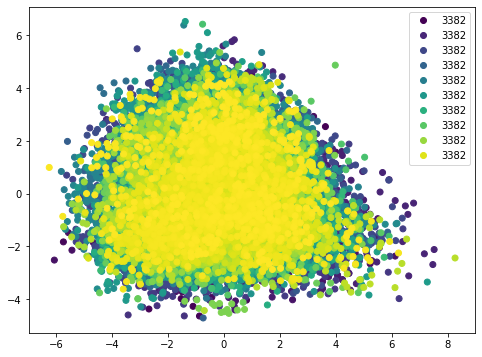

In [ ]:
from sklearn.pipeline import Pipeline
pca = PCA()
pipe = Pipeline([('scaler', preprocessing.MinMaxScaler()), ('pca', pca)])
plt.figure(figsize=(8,6))
Xt = pipe.fit_transform(data)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=toh)
plt.legend(handles=plot.legend_elements()[0], labels=list(labels))
plt.show()

In [ ]:
def transform_pca(X, n):

    pca = PCA(n_components=n)
    pca.fit(X)
    X_new = pca.inverse_transform(pca.transform(X))

    return X_new

rows = 4
cols = 4
comps = 1

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

fig, axes = plt.subplots(rows, 
                         cols, 
                         figsize=(12,12), 
                         sharex=True, 
                         sharey=True)


for row in range(rows):
    for col in range(cols):
        try:
            X_new = transform_pca(X_scaled, comps)
            ax = sns.scatterplot(x=X_scaled[:, 0], 
                                 y=X_scaled[:, 1], 
                                 ax=axes[row, col], 
                                 color='grey', 
                                 alpha=.3)
            ax = sns.scatterplot(x=X_new[:, 0], 
                                 y=X_new[:, 1], 
                                 ax=axes[row, col], 
                                 color='black')
            ax.set_title(f'PCA Components: {comps}');

            comps += 1
        except:
            pass
plt.tight_layout()
plt.savefig('pcavisualize_2.png', dpi=300)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
def create_pipe(clf, do_pca=False, n=2):

    scaler = StandardScaler()
    pca = PCA(n_components=n)

    if do_pca == True:
        combined_features = FeatureUnion([("scaler", scaler), 
                                          ("pca", pca)])
    else:
        combined_features = FeatureUnion([("scaler", scaler)])

    pipeline = Pipeline([("features", combined_features), 
                         ("clf", clf)])


    return pipeline
def get_params(parameters, X, y, pipeline):

    grid = GridSearchCV(pipeline, 
                        parameters, 
                        scoring='accuracy', 
                        n_jobs=1, 
                        cv=3, 
                        error_score='raise')
    grid.fit(X, y)

    return grid
clf = LogisticRegression(random_state=41)
pipeline = create_pipe(clf, do_pca=True)

param_grid = dict(features__pca__n_components = list(range(2,14)),
                 clf__C = [0.1, 1.0, 10, 100],
                 clf__solver = ['liblinear', 'saga'],
                 clf__penalty = ['l2', 'l1'])

grid = get_params(param_grid, data, labels, pipeline)

print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(data, y_test))) 
print("Best parameters: {}".format(grid.best_params_))

In [51]:
x=train_PCA.shape
x=x[1]

In [10]:
%%script false
#Incremental PCA
n_PCA_components = 1008
batch_size=10000
pca = IncrementalPCA(n_PCA_components,batch_size=batch_size)
train_PCA = pca.fit_transform(data)
#test_PCA = pca.transform(data)

In [11]:
#Grid Search CV 
%%script false
from sklearn.model_selection import GridSearchCV
def define_model(learning_rate=0.01,epsilon='9e-03'):   
    
    model = Sequential()
    model.add(InputLayer(input_shape=(x[1],)))
    model.add(Dense(618, kernel_initializer='he_uniform',activation='relu'))
    model.add(Dense(1008, kernel_initializer='he_uniform', activation='sigmoid'))
    model.add(Dense(1008, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_classes,kernel_regularizer=tf.keras.regularizers.l2(0.01),kernel_initializer='he_uniform', activation='softmax'))

    Adam(
    learning_rate=learning_rate,
    beta_1=0.78,
    beta_2=0.776,
    epsilon=epsilon,
    amsgrad=True,
    name="Adam", 
    )    
    
    # compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',      
                  metrics=['Accuracy'])

    return model

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#batch_size = 100
epochs = 3

model = KerasClassifier(build_fn=define_model,  
                        verbose=1)

#dropout_rate = [0.0, 0.2, 0.4]
learning_rate = [0.0001, 0.01]
epsilon=['9e-03','9e-04']
#activation = ['softmax', 'relu', 'sigmoid']
#Also try softplus, tanh, linear, hard_sigmoid 
#init_weights = ['uniform', 'normal', 'he_uniform']
#Also try lecun_uniform, he_normal, glorot_normal, etc. 
#optimizer = ['SGD', 'RMSprop', 'Adam']
#epochs = [1, 5, 10]

#n_jobs=16 uses 16 CPUs. Try not to do -1 on your system as it may hang!!!
# -1 refers to using all available CPUs
#Cross validation, cv=3

param_grid = dict(
                    learning_rate=learning_rate,
                    epsilon=epsilon
                    #activation=activation,
                    #optimizer = ['SGD', 'RMSprop', 'Adam']
                  )

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-2, cv=3)

grid_result = grid.fit(train_PCA, OHE_labels)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean = %f (std=%f) with: %r" % (mean, stdev, param))

Couldn't find program: 'false'


In [24]:
#With Dropout
model = Sequential()
#model.add(InputLayer(input_shape=(n_PCA_components,)))
model.add(Dropout(0.3, input_shape=(x,)))
model.add(Dense(1008,activation='relu'))
model.add(Dense(380,activation='sigmoid'))
model.add(Dense(2048,activation='relu'))
model.add(Dense(n_classes, kernel_regularizer=tf.keras.regularizers.l2(0.001),activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 550)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1008)              555408    
_________________________________________________________________
dense_5 (Dense)              (None, 380)               383420    
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              780288    
_________________________________________________________________
dense_7 (Dense)              (None, 2840)              5819160   
Total params: 7,538,276
Trainable params: 7,538,276
Non-trainable params: 0
_________________________________________________________________


In [11]:
#Direct Feeding without Dropouts 
model = Sequential()
model.add(InputLayer(input_shape=(n_PCA_components,)))
model.add(Dense(1008,activation='relu'))
model.add(Dense(380,activation='sigmoid'))
model.add(Dense(2048,activation='relu'))
model.add(Dense(n_classes, kernel_regularizer=tf.keras.regularizers.l2(0.0001),activation='softmax'))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1008)              2017008   
_________________________________________________________________
dense_1 (Dense)              (None, 380)               383420    
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              780288    
_________________________________________________________________
dense_3 (Dense)              (None, 2840)              5819160   
Total params: 8,999,876
Trainable params: 8,999,876
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.load_weights(baseweight)

In [ ]:
#Pop the top layer and place the number of classes 
model.pop()
model.add(Dense(n_classes, kernel_regularizer=tf.keras.regularizers.l2(0.001),activation='softmax'))
model.summary()

In [ ]:
#Extract Weights from an Existing model and load the weights to new model of same structure 
temp = Sequential()
temp.load(basedir+"model_3_2000.h5")    
weights= temp.get_weights()
model.load_weights(weights)

In [ ]:
#Adam Variations 
Adam(
    learning_rate=0.0001,
    beta_1=0.79,
    beta_2=0.776,
    epsilon=9e-04,
    amsgrad=True,
    name="Adam", 
)

Adam(
    learning_rate=0.01,
    beta_1=0.79,
    beta_2=0.776,
    epsilon=9e-08,
    amsgrad=True,
    name="Adam", 
)

In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(basedir+"Weight_550.h5", 
                            monitor='categorical_accuracy', 
                            verbose=1, 
                            save_best_only=False, 
                            save_weights_only=True, 
                            mode='auto', 
                            #save_freq=1
                            )

early = EarlyStopping(monitor='categorical_accuracy', 
                    min_delta=0, 
                    patience=18, 
                    verbose=1, 
                    mode='auto')

optamizer= Adam(
    learning_rate=0.0001,
    beta_1=0.99,
    beta_2=0.999,
    epsilon=2e-07,
    amsgrad=True,
    name="Adam", 
    )

model.compile(
optimizer=optamizer,
loss='categorical_crossentropy',
metrics=['categorical_accuracy']
)

import datetime
start = datetime.datetime.now()
#Fit the model. Do not forget to use on-hot-encoded Y values. 
model.fit(
        train_PCA,OHE_labels,
        epochs=10,
        #steps_per_epoch= 1008, 
        #batch_size=batch_size,
        verbose=1,
        callbacks=[checkpoint]
        )
end = datetime.datetime.now()
print("Total execution time with PCA is: ", end-start)

Train on 42599 samples
Epoch 1/10
42592/42599 [============================>.] - ETA: 0s - loss: 0.2776 - categorical_accuracy: 0.9668
Epoch 00001: saving model to ./HOG_NN/mataji/Female/7/Weight_550.h5
42599/42599 [==============================] - 200s 5ms/sample - loss: 0.2776 - categorical_accuracy: 0.9668
Epoch 2/10
42592/42599 [============================>.] - ETA: 0s - loss: 0.2576 - categorical_accuracy: 0.9724
Epoch 00002: saving model to ./HOG_NN/mataji/Female/7/Weight_550.h5
42599/42599 [==============================] - 237s 6ms/sample - loss: 0.2576 - categorical_accuracy: 0.9724
Epoch 3/10
42592/42599 [============================>.] - ETA: 0s - loss: 0.2548 - categorical_accuracy: 0.9725
Epoch 00003: saving model to ./HOG_NN/mataji/Female/7/Weight_550.h5
42599/42599 [==============================] - 254s 6ms/sample - loss: 0.2548 - categorical_accuracy: 0.9725
Epoch 4/10
42592/42599 [============================>.] - ETA: 0s - loss: 0.2514 - categorical_accuracy: 0.974

In [44]:
import statistics
print(statistics.median(train_PCA[1]))
#print(statistics.mean(train_PCA[1]))


-0.0016030794249474096


In [33]:
model.save_weights(basedir+"best_trunc_w_550.h5")

In [28]:
model.save(basedir+"best_trunk_2000.h5")

In [73]:
test_PCA = pca.transform(data) #Make sure you are just transforming, not fitting.
#Predict on test dataset
predict_test = model.predict(test_PCA)
predict_test = np.argmax(predict_test, axis=1)
predict_test = le.inverse_transform(predict_test)

In [74]:
##Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(labels, predict_test))

Accuracy =  1.0


__Prediction Report__

<AxesSubplot:>

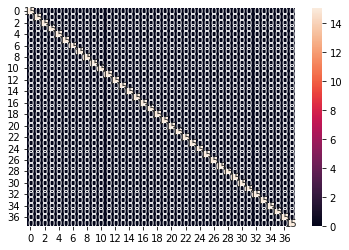

In [75]:
#Confusion Matrix - verify accuracy of each class - Do not do it for classes more than 30
from sklearn.metrics import confusion_matrix
#testY=str(testY)
cm = confusion_matrix(labels, predict_test)
#print(cm)
sns.heatmap(cm, annot=True)

In [45]:
#Check results on a few select images
n=np.random.randint(0,data.shape[0])
print(n)
val = data[n]
print(val.shape)
x = np.expand_dims(val, axis=0) #Expand dims so the input is (num images, x, y, c)
print(x.shape)
# #Expand dims so the input is (num images, x, y, c)
input_img_feature=x
input_img_PCA = pca.transform(input_img_feature)
prediction_img = model.predict(input_img_PCA)
prediction_img = np.argmax(prediction_img, axis=1)
print(prediction_img)
prediction_img = le.inverse_transform(prediction_img)  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_img)
print("The actual label for this image is: ", labels[n])

39772
(2688,)
(1, 2688)
[2651]
The prediction for this image is:  ['6717']
The actual label for this image is:  6717


In [ ]:
SIZE=256
imagepath='./path/Dataset/Vrindhaavan_overall_backup/Vrindavan_overall/1464/Chatshikhar_Cow_Female_13.png'
H=HOG(imagepath,SIZE)
x = np.expand_dims(H, axis=0)
input_img_feature=x
input_img_PCA = pca.transform(input_img_feature)
prediction_img = model.predict(input_img_PCA)
prediction_img = np.argmax(prediction_img, axis=1)
print(prediction_img)
prediction_img = le.inverse_transform(prediction_img)  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_img)
#print("The actual label for this image is: ", test_labels[n])

In [ ]:
from tensorflow.keras import Model
SIZE=256
imagepath='./path/Dataset/Vrindhaavan_overall_backup/Vrindavan_overall/1464/Chatshikhar_Cow_Female_13.png'
H=HOG(imagepath,SIZE)
x = np.expand_dims(H, axis=0)
input_img_feature=x
input_img_PCA = pca.fit_transform(input_img_feature)
all_model=load_model('./Vrindhavan_Overall_sukirti.h5')
prediction_img = all_model.predict(input_img_PCA)
prediction_img = np.argmax(prediction_img, axis=1)
print(prediction_img)
prediction_img = le.inverse_transform(prediction_img)  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_img)
#print("The actual label for this image is: ", test_labels[n])

In [46]:
#Labelwise wise Prediction Check 
import numpy as np
from imutils import paths

dir_path='./path/Dataset/Testing/'
imglbl='mataji'
cnt=0
#all_model=load_model('./HOG_NN/mataji/Female/v2/model_108.h5')
for imagepath in paths.list_images(dir_path+imglbl):
    imgname = imagepath.split("/")[-1]
    print(imgname)
    H=HOG(imagepath)
    x = np.expand_dims(H, axis=0)
    input_img_PCA = pca.transform(x)
    prediction_img = model.predict(input_img_PCA)
    prediction_img = np.argmax(prediction_img, axis=1)
    #print(prediction_img)
    prediction_img = le.inverse_transform(prediction_img)  #Reverse the label encoder to original name
    print("The prediction for this image is: ", prediction_img)

mataji\MatajiGaushala_Cow_Female-4706P.png
The prediction for this image is:  ['3574']
mataji\MatajiGaushala_Cow_Female-4728P.png
The prediction for this image is:  ['4728']
mataji\MatajiGaushala_Cow_Female-4822P.png
The prediction for this image is:  ['4606']
mataji\MatajiGaushala_Cow_Female-4945NP.png
The prediction for this image is:  ['4683']
mataji\MatajiGaushala_Cow_Female-4949P.png
The prediction for this image is:  ['4949']
mataji\MatajiGaushala_Cow_Female-4969NP.png
The prediction for this image is:  ['6398']
mataji\MatajiGaushala_Cow_Female-4998NP.png
The prediction for this image is:  ['5328']
mataji\MatajiGaushala_Cow_Female-5005NP.png
The prediction for this image is:  ['6141']
mataji\MatajiGaushala_Cow_Female-5008NP.png
The prediction for this image is:  ['4364']
mataji\MatajiGaushala_Cow_Female-5015P.png
The prediction for this image is:  ['5015']
mataji\MatajiGaushala_Cow_Female-5041P.png
The prediction for this image is:  ['5041']
mataji\MatajiGaushala_Cow_Female-5042P